# Importing and Configs

In [1]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt

from gym import error, spaces, utils
from gym.utils import seeding
from tabulate import tabulate
from enum import Enum
from copy import copy, deepcopy
from random import randint, random
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from operator import add

from IPython.display import display, clear_output

# Definig Environments

## objects in environment

In [2]:
class WorldObj:
    def __init__(self, name):
        self.name = name
        
    def __repr__(self):
        return " "
    
class Empty(WorldObj):
    def __init__(self):
        super().__init__('empty')
    
class Log(WorldObj):
    def __init__(self):
        super().__init__('log')
    
    def __repr__(self):
        return '_'
    
class Gold(WorldObj):
    def __init__(self):
        super().__init__('gold')
    
    def __repr__(self):
        return 'G'
    
class Food(WorldObj):
    def __init__(self):
        super().__init__('food')
    
    def __repr__(self):
        return '8'
    
    
class Trap(WorldObj):
    def __init__(self):
        super().__init__('trap')
        self.state = None
    
    def __repr__(self):
        return 'X'

class Teleport(WorldObj):
    def __init__(self, dest, chance=0.8):
        super().__init__('teleport')
        self.destination = dest
        self.chance = chance
    
    def __repr__(self):
        return 'T'
    
    
class Stream(WorldObj):
    """
    stream only goes down or right!
    """
    
    def __init__(self, _dir: int):
        super().__init__('stream')
        self.dir = _dir
    
    def __repr__(self):
        return '~'
    
class Miner(WorldObj):
    def __init__(self):
        super().__init__('miner')
    
    def __repr__(self):
        return '*'
        

## Defining Envrionment

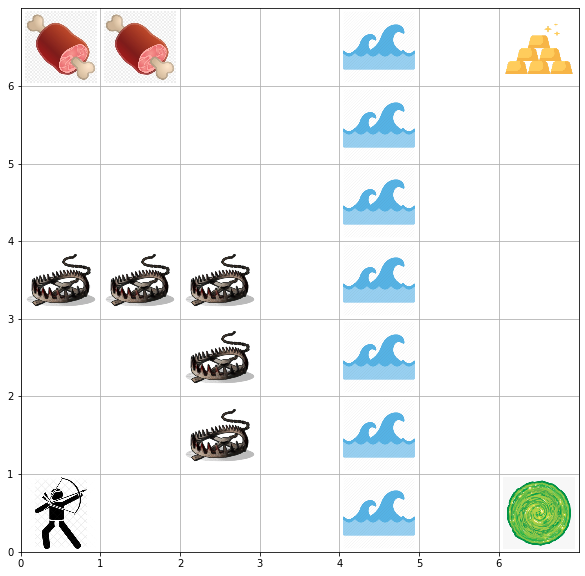

In [3]:
class Action(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3
    LOG_RIGHT = 4
    LOG_DOWN = 5
    LOG_LEFT = 6
    LOG_UP = 7
    
    

class GoldHuntEnv(gym.Env):
    
    metadata = {'render.modes': ['human']}
    static_map_size = 7
    movement_acts = [Action.RIGHT, Action.LEFT, Action.DOWN, Action.UP,]
    craft_acts = [Action.LOG_RIGHT, Action.LOG_LEFT, Action.LOG_DOWN, Action.LOG_UP,]

    def __init__(self, ascii_rep=True):
        self.ascii_rep = ascii_rep
        self.action_space = spaces.Discrete(8)
        self.observation_space = spaces.Discrete(49)
        self.info = {}
        self.max_time_step = 50    
        
    def generate_static_map(self, agent_pos):
        env_map = [[Empty() for _ in range(self.map_size)] for _ in range(self.map_size)]
        env_map[2][1] = Trap()
        env_map[2][2] = Trap()
        env_map[2][3] = Trap()
        env_map[1][3] = Trap()
        env_map[0][3] = Trap()
        
        env_map[0][6] = Food()
        env_map[1][6] = Food()
        
        env_map[6][0] = Teleport(dest=[0, 6])
        env_map[6][6] = Gold()
        
        for i in range(self.map_size):
            env_map[4][i] = Stream(_dir=Action.RIGHT.value)
            
        return env_map

    def get_pos_obj(self, pos):
        return self.env_map[pos[0]][pos[1]]

    
    def _get_next_pos(self, current_loc, action):
        action_dir = Action(action)
        next_pos = copy(current_loc)
        
        if action_dir not in self.movement_acts:
            return current_loc
        
        if action_dir == Action.RIGHT:
            next_pos[1] = self._restricted_move(next_pos[1], 1)
        elif action_dir == Action.LEFT:
            next_pos[1] = self._restricted_move(next_pos[1], -1)
        elif action_dir == Action.UP:
            next_pos[0] = self._restricted_move(next_pos[0], -1)
        elif action_dir == Action.DOWN:
            next_pos[0] = self._restricted_move(next_pos[0], 1)
            
        return next_pos
        
        
    def _restricted_move(self, init_val, res):
        new_val = init_val + res
        if new_val >= self.map_size:
            new_val = self.map_size - 1
        elif new_val < 0:
            new_val = 0
        return new_val
    
    
    def pos_to_state(self, pos):
        return pos[0]*self.map_size + pos[1]
    
    def on_border(self, pos):
        if pos[0] == 0 or pos[0] == self.map_size-1 or pos[1] == 0 or pos[1] == self.map_size-1:
            return True
        return False
    
    
    def craft_log(self, current_pos, action: int):
        """
        returns True if log is crafted, False otherwise
        """
        log_loc = self._get_next_pos(current_pos, action-4)
        if log_loc == current_pos:
            return False
        
        self.env_map[log_loc[0]][log_loc[1]] = Log()
        return True
        
    
    def step(self, action: int):
        self.info['statu'] = ""
        self.info['step'] = self.time_step
        self.time_step += 1
        
        done = self.time_step > self.max_time_step 
        reward = -1
        
        self.info['action'] = f"agent performed {Action(action)}"
        curr_obj = self.get_pos_obj(self.agent_pos)
        
        # agent was trapped before
        if isinstance(curr_obj, Trap) and Action(action) in self.movement_acts:
            trap_state = curr_obj.state
            if trap_state is None or action != (trap_state+2)%4:
                self.info['status'] = f"Agent in trap with previous action of {None if curr_obj.state is None else Action(curr_obj.state)}"
                curr_obj.state = action
                self.info['cum_r'] += reward
                return self.pos_to_state(self.agent_pos), reward, done, self.info
            else:
                self.info['status'] = f"Agent broke the trap"
                self.env_map[self.agent_pos[0]][self.agent_pos[1]] = Empty()        
        
        # agent crafts a log
        if Action(action) in self.craft_acts:
            is_crafted = self.craft_log(self.agent_pos, action)
            reward = -5
            if is_crafted:
                self.info['status'] = 'agent crafted a log'
            self.info['cum_r'] += reward
            return self.pos_to_state(self.agent_pos), reward, done, self.info
        

        next_pos = self._get_next_pos(self.agent_pos, action)
        next_obj = self.get_pos_obj(next_pos)

        # stream takes agent when he falls into it
        if isinstance(next_obj, Stream):
            self.info['status'] = ('agent fell into a stream')
            while isinstance(next_obj, Stream):
                next_pos = self._get_next_pos(next_pos, next_obj.dir)
                next_obj = self.get_pos_obj(next_pos)
                
                if self.on_border(next_pos):
                    if next_pos[0] == self.map_size-1 and next_pos[1] == self.map_size-1:
                        done = True
                        reward = -20
                    elif next_pos[0] == self.map_size-1 and Action(next_obj.dir) == Action.DOWN:
                        next_pos[1] = self._restricted_move(next_pos[1], 1)
                    elif next_pos[1] == self.map_size-1 and Action(next_obj.dir) == Action.RIGHT:
                        next_pos[0] = self._restricted_move(next_pos[0], 1)
                    
                next_obj = self.get_pos_obj(next_pos)                              
        
        # gets hurt by falling into trap
        if isinstance(next_obj, Trap):
            self.info['status'] = 'agent fell into a trap'
            reward = -3
            
        if isinstance(next_obj, Teleport):
            """ manually non deterministic setup for this env """
            
            if random() <= next_obj.chance:
                self.info['status'] = f'agent teleported to {next_obj.destination} and ate food!'
                self.agent_pos = next_obj.destination
                self._clear_pos(next_obj.destination)
                reward = 5
                self.info['cum_r'] += reward
                return self.pos_to_state(self.agent_pos), reward, done, self.info
        
        # refills energy by eating food
        if isinstance(next_obj, Food):
            self.info['status'] = 'agent ate food!'
            self._clear_pos(next_pos)
            reward = 5
        
        # agent finds the gold
        if isinstance(next_obj, Gold):
            self.info['status'] = 'agent found the GOLD!'
            done = True
            reward = 10
            
        self.agent_pos = next_pos
        self.info['cum_r'] += reward
        
        return self.pos_to_state(self.agent_pos), reward, done, self.info

    def _clear_pos(self, pos):
        self.env_map[pos[0]][pos[1]] = Empty()
    
    def reset(self):
        self.info = {
            'cum_r': 0,
            'action': "",
            'status': "",
            'step': 0
        }
        
        self.map_size = self.static_map_size
        self.agent_pos = [0, 0]
        self.env_map = self.generate_static_map(self.agent_pos)    
        self.prev_action = None
        self.time_step = 0
        
        return self.pos_to_state(self.agent_pos)
  
    def get_env_rep(self):
        env_map_top_layer = deepcopy(self.env_map)
        env_map_top_layer[self.agent_pos[0]][self.agent_pos[1]] = Miner()
        
        return tabulate(env_map_top_layer, headers=[], tablefmt='grid')

    def get_rgb_rep(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(0, self.map_size)
        ax.set_ylim(0, self.map_size)
        
        show_layer = deepcopy(self.env_map)
        show_layer[self.agent_pos[0]][self.agent_pos[1]] = Miner()
        
        for i in range(len(show_layer)):
            for j in range(len(show_layer)):
                obj = show_layer[i][j]
                
                if isinstance(obj, Gold):
                    path = './images/gold.png'
                elif isinstance(obj, Trap):
                    path = './images/trap.png'
                elif isinstance(obj, Food):
                    path = './images/food.png'
                elif isinstance(obj, Log):
                    path = './images/log.png'
                elif isinstance(obj, Stream):
                    path = './images/stream.png'
                elif isinstance(obj, Teleport):
                    path = './images/teleport.png'
                elif isinstance(obj, Miner):
                    path = './images/agent.png'
                else:
                    continue
                    
                
                obj_repr = AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.28),
                       list(map(add, [i, j], [0.5, 0.5])), frameon=False)
                ax.add_artist(obj_repr)
        
        plt.xticks([i for i in range(self.map_size)])
        plt.yticks([i for i in range(self.map_size)])
        plt.grid()
        plt.show()
        
    
    def render(self, mode='human'):
        if self.ascii_rep:
            print(self.get_env_rep())
        else:
            self.get_rgb_rep()
        

    def close(self):
        pass
    
env = GoldHuntEnv(ascii_rep=False)
env.reset()
env.render()

## Manually Playing in Environment

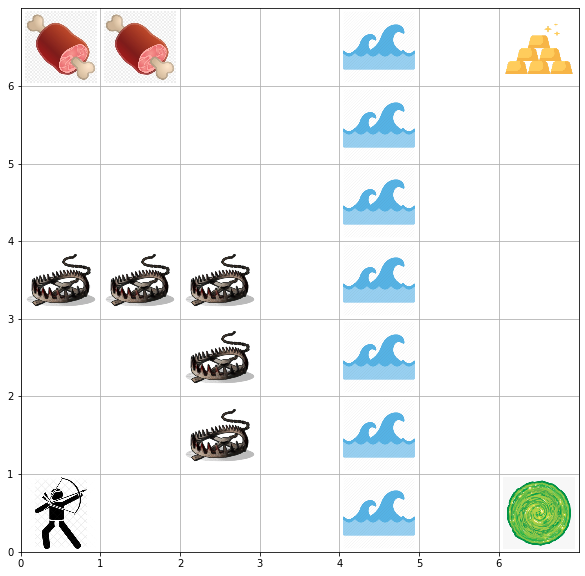

KeyboardInterrupt: Interrupted by user

In [4]:
def play_in_env(env):
    done = False
    clear_output(wait=True)
    env.render()

    while not done:
        action = int(input())
        
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
env = GoldHuntEnv(ascii_rep=False)
env.reset()
play_in_env(env)

## Random agent playing

In [ ]:

def random_agent_play(env, max_steps=10):
    done = False
    clear_output(wait=True)
    env.render()
    step = 0
    
    while not done and step < max_steps:
        
        action = randint(0, 4)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.8)
        step += 1
        
        
env = GoldHuntEnv(ascii_rep=False)
env.reset()
random_agent_play(env, max_steps=50)